In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from pygam import LogisticGAM, s, f
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import sys
sys.path.append('../src') 

from data_pipeline.extractor import execute_query

In [40]:
query = """
SELECT s.*, a.hospital_expire_flag as mortality
FROM sapsii s
LEFT JOIN admissions a
ON s.subject_id = a.subject_id
AND s.hadm_id = a.hadm_id;
"""

# Execute the query
df = execute_query(query)

c:\Users\hassa\GAMs_for_Mortality_Prediction\research_notebooks\../src\data_pipeline\extractor.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


In [41]:
df.head()

,subject_id,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,pao2fio2_score,...,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,mortality
0,55973,152234,200001,44,0.326364,12,4.0,5.0,0.0,NaN,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6,0
1,27513,163557,200003,30,0.106398,7,4.0,5.0,0.0,NaN,...,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0,8,0
2,10950,189514,200006,20,0.037205,7,2.0,5.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6,0
3,20707,129310,200007,18,0.029295,7,0.0,5.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6,0
4,29904,129607,200009,21,0.041754,7,0.0,5.0,0.0,6.0,...,0.0,0.0,3.0,0.0,0.0,NaN,0.0,0,0,0


In [42]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'sapsii', 'sapsii_prob',
       'age_score', 'hr_score', 'sysbp_score', 'temp_score', 'pao2fio2_score',
       'uo_score', 'bun_score', 'wbc_score', 'potassium_score', 'sodium_score',
       'bicarbonate_score', 'bilirubin_score', 'gcs_score',
       'comorbidity_score', 'admissiontype_score', 'mortality'],
      dtype='object')

Training set class distribution:
mortality
1    5287
0    5287
Name: count, dtype: int64
Test set class distribution:
mortality
1    1322
0    1322
Name: count, dtype: int64
Confusion Matrix:
[[ 992  330]
 [ 297 1025]]
ROC AUC: 0.8521
Accuracy: 0.7629
F1 Score: 0.7658
Correlation with SAPSII Probability: -0.1105


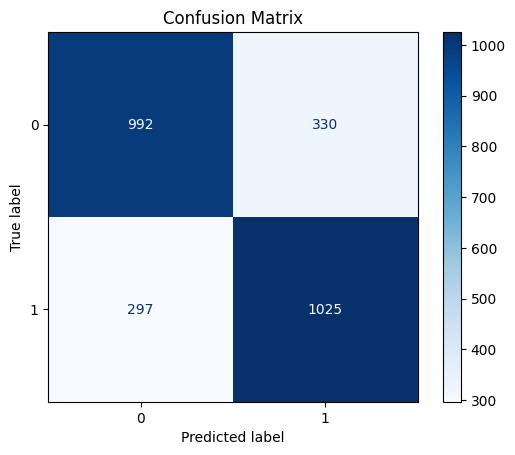

In [48]:

# Train a Generalized Additive Model (GAM) on the balanced dataset
gam_balanced = LogisticGAM().fit(X_train_balanced, y_train_balanced)

# Predict probabilities and binary outcomes on the balanced test set
y_pred_prob_balanced = gam_balanced.predict_proba(X_test_balanced)
y_pred_balanced = gam_balanced.predict(X_test_balanced)

# Calculate evaluation metrics for the balanced dataset
roc_auc_balanced = roc_auc_score(y_test_balanced, y_pred_prob_balanced)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

# Calculate confusion matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Print the confusion matrix
print(f"Confusion Matrix:\n{conf_matrix_balanced}")

# Print metrics
print(f"ROC AUC: {roc_auc_balanced:.4f}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")

# Calculate correlation with SAPSII Probability on the balanced test set
correlation_balanced = pd.Series(y_pred_prob_balanced).corr(df['sapsii_prob'].loc[y_test_balanced.index])
print(f"Correlation with SAPSII Probability: {correlation_balanced:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_balanced)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Training set class distribution:
mortality
0    10574
1    10574
Name: count, dtype: int64
Test set class distribution:
mortality
1    2644
0    2644
Name: count, dtype: int64
ROC AUC: 0.8453
Accuracy: 0.7589
F1 Score: 0.7545
Correlation with SAPSII Probability: 0.0026


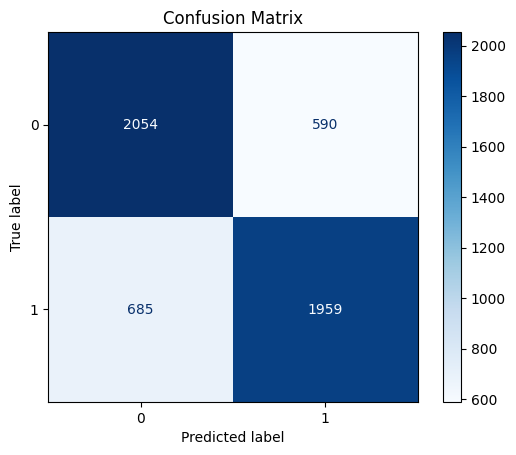

In [49]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from pygam import LogisticGAM
import matplotlib.pyplot as plt

# Exclude specific columns
df_filtered = df.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'sapsii', 'sapsii_prob'])

# Replace NaNs with 0
df_filtered = df_filtered.fillna(0)

# Separate majority and minority classes
df_majority = df_filtered[df_filtered.mortality == 0]
df_minority = df_filtered[df_filtered.mortality == 1]

# Duplicate minority class
df_minority_upsampled = pd.concat([df_minority] * 2)

# Downsample majority class to match the size of the upsampled minority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority_upsampled),  # match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

# Separate features and target variable
y_balanced = df_balanced['mortality']
X_balanced = df_balanced.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train_balanced.value_counts())

print("Test set class distribution:")
print(y_test_balanced.value_counts())

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

# Train a Generalized Additive Model (GAM) on the balanced dataset
gam_balanced = LogisticGAM().fit(X_train_balanced, y_train_balanced)

# Predict probabilities and binary outcomes on the balanced test set
y_pred_prob_balanced = gam_balanced.predict_proba(X_test_balanced)
y_pred_balanced = gam_balanced.predict(X_test_balanced)

# Calculate evaluation metrics for the balanced dataset
roc_auc_balanced = roc_auc_score(y_test_balanced, y_pred_prob_balanced)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

# Calculate confusion matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Print metrics
print(f"ROC AUC: {roc_auc_balanced:.4f}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")

# Calculate correlation with SAPSII Probability on the balanced test set
correlation_balanced = pd.Series(y_pred_prob_balanced).corr(df['sapsii_prob'].loc[y_test_balanced.index])
print(f"Correlation with SAPSII Probability: {correlation_balanced:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_balanced)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Reduce the size of the background data using k-means clustering
background_data_balanced = shap.kmeans(X_train_balanced, 100)  # Cluster into 100 representative samples

# Use the KernelExplainer for SHAP values with reduced background data
explainer_balanced = shap.KernelExplainer(predict_gam_proba, background_data_balanced)
shap_values_balanced = explainer_balanced.shap_values(X_test_balanced, nsamples=100)  # Adjust nsamples as needed

# Plot SHAP summary plot
shap.summary_plot(shap_values_balanced, X_test_balanced, feature_names=X.columns)


NameError: name 'predict_gam_proba' is not defined

  0%|          | 0/2644 [00:00<?, ?it/s]

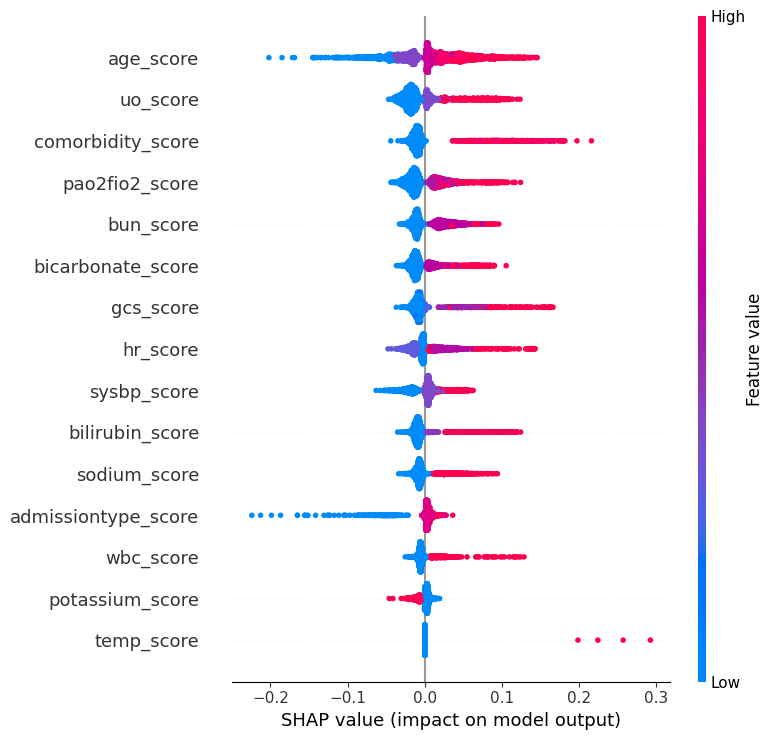

In [30]:
# Reduce the size of the background data by randomly sampling
background_data_balanced = shap.sample(X_train_balanced, 100)  # Select 100 samples for the background

# Use the KernelExplainer for SHAP values with reduced background data
explainer_balanced = shap.KernelExplainer(predict_gam_proba, background_data_balanced)
shap_values_balanced = explainer_balanced.shap_values(X_test_balanced, nsamples=100)  # Adjust nsamples as needed

# Plot SHAP summary plot
shap.summary_plot(shap_values_balanced, X_test_balanced, feature_names=X.columns)


# Random Forest

Training set class distribution:
mortality
1    5287
0    5287
Name: count, dtype: int64
Test set class distribution:
mortality
1    1322
0    1322
Name: count, dtype: int64
Confusion Matrix:
[[ 961  361]
 [ 300 1022]]
ROC AUC: 0.8289
Accuracy: 0.7500
F1 Score: 0.7556
Correlation with SAPSII Probability: -0.0664


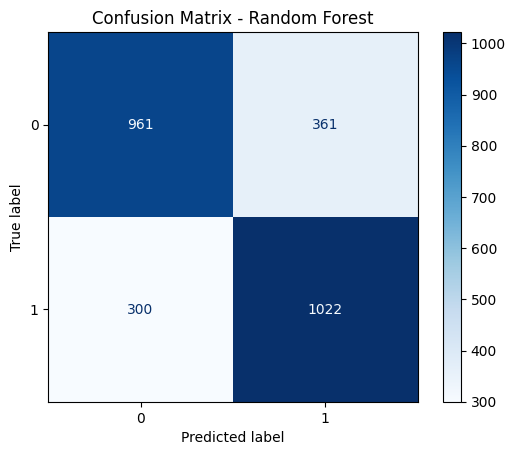

In [46]:
# Separate majority and minority classes
df_majority = df_filtered[df_filtered.mortality == 0]
df_minority = df_filtered[df_filtered.mortality == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=int(len(df_minority)),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable
y_balanced = df_balanced['mortality']
X_balanced = df_balanced.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train_balanced.value_counts())

print("Test set class distribution:")
print(y_test_balanced.value_counts())

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

# Train a Random Forest model on the balanced dataset
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)

# Predict probabilities and binary outcomes on the balanced test set
y_pred_prob_balanced = rf_balanced.predict_proba(X_test_balanced)[:, 1]
y_pred_balanced = rf_balanced.predict(X_test_balanced)

# Calculate evaluation metrics for the balanced dataset
roc_auc_balanced = roc_auc_score(y_test_balanced, y_pred_prob_balanced)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

# Calculate confusion matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Print the confusion matrix
print(f"Confusion Matrix:\n{conf_matrix_balanced}")

# Print metrics
print(f"ROC AUC: {roc_auc_balanced:.4f}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")

# Calculate correlation with SAPSII Probability on the balanced test set
correlation_balanced = pd.Series(y_pred_prob_balanced).corr(df['sapsii_prob'].loc[y_test_balanced.index])
print(f"Correlation with SAPSII Probability: {correlation_balanced:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_balanced)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:

# SHAP values for Random Forest model
explainer_rf = shap.TreeExplainer(rf_balanced)
shap_values_rf = explainer_rf.shap_values(X_test_balanced)

# Plot SHAP summary plot
shap.summary_plot(shap_values_rf[1], X_test_balanced, feature_names=X.columns)


# XGboost

Training set class distribution:
mortality
1    5287
0    5287
Name: count, dtype: int64
Test set class distribution:
mortality
1    1322
0    1322
Name: count, dtype: int64
Confusion Matrix:
[[1008  314]
 [ 312 1010]]
ROC AUC: 0.8511
Accuracy: 0.7632
F1 Score: 0.7634
Correlation with SAPSII Probability: -0.1525


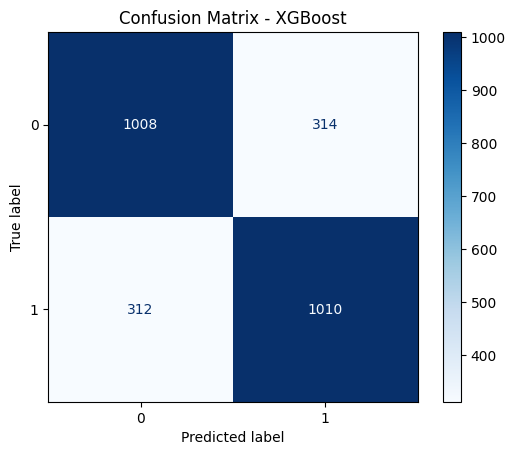

In [47]:
# Separate majority and minority classes
df_majority = df_filtered[df_filtered.mortality == 0]
df_minority = df_filtered[df_filtered.mortality == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=int(len(df_minority)),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable
y_balanced = df_balanced['mortality']
X_balanced = df_balanced.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train_balanced.value_counts())

print("Test set class distribution:")
print(y_test_balanced.value_counts())

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

# Train an XGBoost model on the balanced dataset
xgb_balanced = XGBClassifier(random_state=42)
xgb_balanced.fit(X_train_balanced, y_train_balanced)

# Predict probabilities and binary outcomes on the balanced test set
y_pred_prob_balanced = xgb_balanced.predict_proba(X_test_balanced)[:, 1]
y_pred_balanced = xgb_balanced.predict(X_test_balanced)

# Calculate evaluation metrics for the balanced dataset
roc_auc_balanced = roc_auc_score(y_test_balanced, y_pred_prob_balanced)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

# Calculate confusion matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Print the confusion matrix
print(f"Confusion Matrix:\n{conf_matrix_balanced}")

# Print metrics
print(f"ROC AUC: {roc_auc_balanced:.4f}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")

# Calculate correlation with SAPSII Probability on the balanced test set
correlation_balanced = pd.Series(y_pred_prob_balanced).corr(df['sapsii_prob'].loc[y_test_balanced.index])
print(f"Correlation with SAPSII Probability: {correlation_balanced:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_balanced)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [ ]:

# SHAP values for XGBoost model
explainer_xgb = shap.TreeExplainer(xgb_balanced)
shap_values_xgb = explainer_xgb.shap_values(X_test_balanced)

# Plot SHAP summary plot
shap.summary_plot(shap_values_xgb, X_test_balanced, feature_names=X.columns)


Training set class distribution:
mortality
1    5296
0    5278
Name: count, dtype: int64
Test set class distribution:
mortality
0    1331
1    1313
Name: count, dtype: int64
Confusion Matrix:
[[938 393]
 [321 992]]
ROC AUC: 0.8029
AUC PRC: 0.7721
Accuracy: 0.7300
F1 Score: 0.7354
Correlation with SAPSII Probability: -0.0598


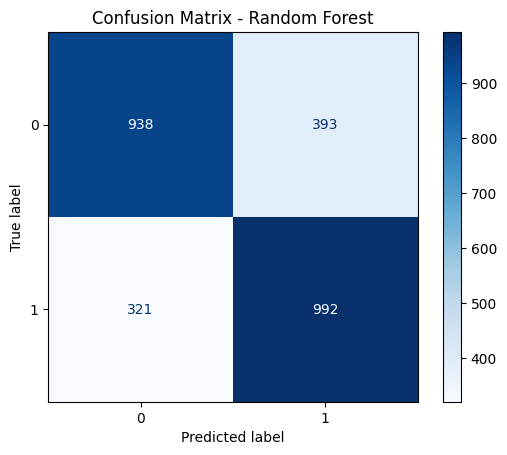

In [35]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Separate majority and minority classes
df_majority = df_filtered[df_filtered.mortality == 0]
df_minority = df_filtered[df_filtered.mortality == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable
y_balanced = df_balanced['mortality']
X_balanced = df_balanced.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train_balanced.value_counts())

print("Test set class distribution:")
print(y_test_balanced.value_counts())

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

# Train a Random Forest model on the balanced dataset
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)

# Predict probabilities and binary outcomes on the balanced test set
y_pred_prob_balanced = rf_balanced.predict_proba(X_test_balanced)[:, 1]
y_pred_balanced = rf_balanced.predict(X_test_balanced)

# Calculate evaluation metrics for the balanced dataset
roc_auc_balanced = roc_auc_score(y_test_balanced, y_pred_prob_balanced)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

# Calculate Precision-Recall Curve and AUC PRC
precision, recall, _ = precision_recall_curve(y_test_balanced, y_pred_prob_balanced)
auc_prc_balanced = auc(recall, precision)

# Calculate confusion matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Print the confusion matrix
print(f"Confusion Matrix:\n{conf_matrix_balanced}")

# Print metrics
print(f"ROC AUC: {roc_auc_balanced:.4f}")
print(f"AUC PRC: {auc_prc_balanced:.4f}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")

# Calculate correlation with SAPSII Probability on the balanced test set
correlation_balanced = pd.Series(y_pred_prob_balanced).corr(df['sapsii_prob'].loc[y_test_balanced.index])
print(f"Correlation with SAPSII Probability: {correlation_balanced:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_balanced)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:

# SHAP values for Random Forest model
explainer_rf = shap.TreeExplainer(rf_balanced)
shap_values_rf = explainer_rf.shap_values(X_test_balanced)

# Plot SHAP summary plot
shap.summary_plot(shap_values_rf[1], X_test_balanced, feature_names=X.columns)
